# OSM vs ENTSOE validation: comparison for Austria and Macedonia

This notebook is a follow-up notebook to the comparative analysis, where a threefold difference between OSM and ENTSOE was observed. This notebook aim to delve deeper into the root causes of this disparity and seek a thorough understanding of the intricacies involved using resource files for Austria (AT) and North Macedonia (MK).

## Data Sources
### OpenStreetMap (OSM)

- OSM is a collaborative mapping platform that provides open-access geographical data. Austria (AT) and North Macedonia (MK) OSM data was used in this analysis, you can download it from the following link:  
  - [Austria](https://drive.google.com/drive/folders/1zKlh_FKYZlWk0RAQQlhzUdosXa3j-XVN?usp=drive_link)
  - [North Macedonia](https://drive.google.com/drive/folders/1xOI-0XEixYJvTwP0Hej4q3V-nEKbmKK3?usp=drive_link).

### ENTSOE
- ENTSOE represents a European organization of transmission system operators in the field of electricity. The ENTSOE dataset used here is based on their unofficial ENTSO-E dataset processed by GridKit. To access the ENTSOE data used in this analysis, you can download it from the following link: [ENTSOE Data](https://github.com/PyPSA/pypsa-eur/raw/master/data/entsoegridkit/lines.csv). For more information about the data sources, check [here](https://github.com/PyPSA/pypsa-eur/tree/master/data/entsoegridkit)

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import pypsa
import json
from shapely import wkt
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import seaborn as sns
import re
from geopy.distance import geodesic as GD

%matplotlib inline
pd.set_option("display.max_columns", 1000)
pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings('ignore')

/Users/gbotemi/miniconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning: The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 
  warnings.warn(


ToDo: Automate download process
Download the resources that is needed to run this notebook from the following links
- `https://drive.google.com/drive/folders/1zKlh_FKYZlWk0RAQQlhzUdosXa3j-XVN?usp=drive_link`
- `https://drive.google.com/drive/folders/1xOI-0XEixYJvTwP0Hej4q3V-nEKbmKK3?usp=drive_link`

## Resource Paths

In this notebook, we are working with data resources for Austria (AT) and North Macedonia (MK). We have defined file paths for these resources as follows:

- Austria Resource Path: `at_path = "at_resources"`
- North Macedonia Resource Path: `mk_path = "mk_resources`

These paths point to the directories where relevant data files are located. We will use these paths to access and analyze the data for our comparative analysis.


In [2]:
# folder directory for at and mk

at_path = "at_resources"
mk_path = "mk_resources"

## Base Network Data

In the following code, we are loading data from CSV files representing the base network lines for Austria (AT) and North Macedonia (MK). These files contain information about the network infrastructure for both regions, which is essential for our comparative analysis.

- **Austria Base Network Lines:** Loaded from `at_path/base_network/all_lines_build_network.csv`.
- **North Macedonia Base Network Lines:** Loaded from `mk_path/base_network/all_lines_build_network.csv`.

We will use this data to delve deeper into the comparative analysis between the two regions.


In [3]:
# Read data from CSV files for Austria (AT) and North Macedonia (MK) base network lines.
at_base_network_lines_csv = pd.read_csv(f"{at_path}/base_network/all_lines_build_network.csv")
at_base_network_lines_csv["geometry"] = at_base_network_lines_csv.geometry.apply(wkt.loads)
at_base_network_lines = gpd.GeoDataFrame(at_base_network_lines_csv, geometry="geometry", crs="EPSG:4326")

mk_base_network_lines_csv = pd.read_csv(f"{mk_path}/base_network/all_lines_build_network.csv")
mk_base_network_lines_csv["geometry"] = mk_base_network_lines_csv.geometry.apply(wkt.loads)
mk_base_network_lines = gpd.GeoDataFrame(mk_base_network_lines_csv, geometry="geometry", crs="EPSG:4326")

In [4]:
# Load clean, raw, and country shapefiles with GeoPandas.
at_osm_clean_lines = gpd.read_file(f"{at_path}/osm/clean/all_clean_lines.geojson")
at_osm_raw_lines = gpd.read_file(f"{at_path}/osm/raw/all_raw_lines.geojson")
at_country_shape = gpd.read_file(f"{at_path}/shapes/country_shapes.geojson")

mk_osm_clean_lines = gpd.read_file(f"{mk_path}/osm/clean/all_clean_lines.geojson")
mk_osm_raw_lines = gpd.read_file(f"{mk_path}/osm/raw/all_raw_lines.geojson")
mk_country_shape = gpd.read_file(f"{mk_path}/shapes/country_shapes.geojson")


In [5]:
# load entsoe line.csv with pandas dataframe
entsoe_ref_df = pd.read_csv("lines.csv", delimiter=",", quotechar="'")

# apply well known text(wkt) to format the geometry column properly
entsoe_ref_df["geometry"] = entsoe_ref_df.geometry.apply(wkt.loads)

# load the data into a geopandas dataframe and format it using a compatible crs
entsoe_ref = gpd.GeoDataFrame(entsoe_ref_df, geometry="geometry", crs="EPSG:3035")

# convert voltage from kV to V
entsoe_ref["voltage"] = entsoe_ref.voltage * 1000

In [6]:
# reprojecting length of the lines to ESPG:3035

at_base_network_lines["reprojected_length"] = at_base_network_lines.to_crs("EPSG:3035").length
at_osm_clean_lines["reprojected_length"] = at_osm_clean_lines.to_crs("EPSG:3035").length
at_osm_raw_lines["reprojected_length"] = at_osm_raw_lines.to_crs("EPSG:3035").length

mk_base_network_lines["reprojected_length"] = mk_base_network_lines.to_crs("EPSG:3035").length
mk_osm_clean_lines["reprojected_length"] = mk_osm_clean_lines.to_crs("EPSG:3035").length
mk_osm_raw_lines["reprojected_length"] = mk_osm_raw_lines.to_crs("EPSG:3035").length


In [7]:
# length of entsoe is already in ESPG:3035. copying it into the same column as the other files to make it easy to interact with
entsoe_ref["reprojected_length"] = entsoe_ref['length']

In [8]:
def percentage_change(new_value: float, original_value: float) -> float:
    """
    Calculate the percentage change between two numbers.

    Parameters:
    - new_value (float): The new value.
    - original_value (float): The original value.

    Returns:
    - float: The percentage change between the new value and the original value.
    """
    if new_value == original_value:
        return 0  # The numbers are the same, so the percentage change is 0.

    # Calculate the percentage difference using the formula
    percentage_change = (
        abs((new_value - original_value)) / (original_value)) * 100

    return percentage_change

def split_col(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    Function to split column by ; and explode the values 
    """
    if type(df[col][0]) == str:
        df[col] = df[col].str.split(";")
        df = df.explode(col)

    return df

def preprocess_raw_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Function to split col, 
    filter data, 
    replace nan values, 
    convert voltage column to integer, 
    and rename columns
    """

    if "tags.voltage" in df.columns.tolist():
        df = df.rename(columns={"tags.voltage": "voltage", "Length": "length"})

    df = split_col(df, 'voltage')
    df = df[df['voltage'] != 'low']
    df['voltage'] = df['voltage'].replace(np.nan, 0)
    df['voltage'] = df['voltage'].astype(int)

    return df

def fill_missing_voltage(data: pd.DataFrame) -> pd.DataFrame:
    """
    Fill missing voltage values in the given data for 220kV and 380kV.

    Parameters:
    data (pd.DataFrame): The input data containing voltage information.

    Returns:
    pd.DataFrame: The updated data with missing voltage values filled.

    """
    for idx in [220000, 380000]:
        if (data.loc[:, 'rebase_voltage'] != idx).all():
            dicts = pd.DataFrame([{
                "rebase_voltage": idx,
                "reprojected_length": np.nan,
                "data": "entsoe_ref"
            }])
            data = pd.concat([dicts, data], ignore_index=True)
    return data


def high_voltage_df(df: pd.DataFrame, data_col: str,
                    country_code: str) -> pd.DataFrame:
    """
    Function takes dataframe and data_col to distinguish the data.
    it creates a new dataframe by filtering for high voltage and grouping by sum of length
    """
    if_country_code = f"if_{country_code}"
    df['rebase_voltage'] = df.voltage.apply(lambda row: int(220000) if (
        (row >= 220000) and (row < 380000)) else (int(380000)
                                                  if (row >= 380000) else row))

    # check if in entsoe data before applying filter
    if if_country_code in df.columns.tolist():

        df = (df[(df[if_country_code] == True)
                 & (df['rebase_voltage'] >= 220000)][[
                     "rebase_voltage", "reprojected_length"
                 ]].groupby(["rebase_voltage"
                             ])["reprojected_length"].sum().reset_index())

    else:
        df = (df[df["rebase_voltage"] >= 220000][[
            "rebase_voltage", "reprojected_length"
        ]].groupby(["rebase_voltage"
                    ])["reprojected_length"].sum().reset_index())

    # create new column with col_name
    df['data'] = data_col

    df = fill_missing_voltage(df)

    return df

def barplot_comparison_plot(df: pd.DataFrame, country: str, simplified: str="") -> None:
    """
    Function creates a comparison plot for osm_clean, osm_raw and entsoe data
    country: will be used to identify the country plot
    """

    plt.figure(figsize=(15, 5))
    sns.barplot(x="rebase_voltage", y="reprojected_length", hue="data", data=df)
    plt.xlabel("voltage(v)")
    plt.ylabel("length(km)")
    plt.title(
        f"Comparison of the osm_raw, osm_clean and entsoe data in High Voltages for {country.upper()} {simplified}"
    )
    plt.legend(title="Data", loc="upper right")
    plt.show()

    return None

def geospatial_plot(
        voltage_level: int,
        country_code: str,
        country_shape: gpd.GeoDataFrame,
        osm_raw_lines: gpd.GeoDataFrame,
        osm_clean_lines: gpd.GeoDataFrame,
        osm_base_network_lines: gpd.GeoDataFrame,
        entsoe_ref: gpd.GeoDataFrame,
        tolerance_level: int = 0.0):
    """
    Function takes voltage level and plot a geospatial plot based on the voltage_level
    """

    country_code = country_code.lower()

    ax = country_shape.plot(edgecolor='grey', alpha=.5, figsize=(15,10),cmap='OrRd')
    osm_raw_lines[osm_raw_lines['rebase_voltage'] == voltage_level] \
                .geometry.simplify(tolerance_level) \
                .plot(figsize=(15,10), color="red", alpha=0.2, ax=ax, label='raw')
    osm_clean_lines[osm_clean_lines['rebase_voltage'] == voltage_level] \
                .geometry.simplify(tolerance_level) \
                .plot(figsize=(15,10), color="blue", alpha=0.5, ax=ax, label='clean')
    osm_base_network_lines[osm_base_network_lines['rebase_voltage'] == voltage_level] \
                .geometry.simplify(tolerance_level) \
                .plot(figsize=(15,10), color="orange", alpha=0.8, ax=ax, label='base_network')

    # to handle empty values in entsoe data in voltage level 220000 in MK data
    if len(entsoe_ref[(entsoe_ref[f'if_{country_code}'] == True) \
                & (entsoe_ref['voltage'] == voltage_level)]) is not 0:
        entsoe_ref[(entsoe_ref[f'if_{country_code}'] == True) & (entsoe_ref['voltage'] == voltage_level)] \
                    .geometry.simplify(tolerance_level) \
                    .plot(figsize=(15,10), color='green', alpha=1.0, ax=ax, label='entsoe')

    plt.title(f"Comparison of the osm_raw, osm_clean and entsoe data in High Voltages for {country_code.upper()} ({voltage_level}V)")
    plt.xlabel("longtitude")
    plt.ylabel("latitude")
    plt.legend()
    plt.show()

In [9]:
# create a new column to easily identify AT and MK in entsoe_ref
entsoe_ref[f"if_at"] = entsoe_ref.within(at_country_shape["geometry"][0])
entsoe_ref[f"if_mk"] = entsoe_ref.within(mk_country_shape["geometry"][0])

In [10]:
# Clean OSM raw data, addressing non-uniform column names and NaN values.
at_osm_raw_lines = preprocess_raw_data(at_osm_raw_lines)
mk_osm_raw_lines = preprocess_raw_data(mk_osm_raw_lines)

In [11]:
# Filtering high-voltage lines from osm_clean, osm_raw, osm_base_network_csv and entose_csv

df_at_osm_clean_lines = high_voltage_df(at_osm_clean_lines, 'osm_clean', 'at')
df_at_osm_raw_lines = high_voltage_df(at_osm_raw_lines, 'osm_raw', 'at')
df_at_osm_base_network_lines = high_voltage_df(at_base_network_lines, 'osm_base_network', 'at')
df_at_entsoe_lines = high_voltage_df(entsoe_ref, 'entsoe_ref', 'at')

df_mk_osm_clean_lines = high_voltage_df(mk_osm_clean_lines, 'osm_clean', 'mk')
df_mk_osm_raw_lines = high_voltage_df(mk_osm_raw_lines, 'osm_raw', 'mk')
df_mk_osm_base_network_lines = high_voltage_df(mk_base_network_lines, 'osm_base_network', 'mk')
df_mk_entsoe_lines = high_voltage_df(entsoe_ref, 'entsoe_ref', 'mk')


In [12]:
# merge osm_clean, osm_raw and entsoe preprocess data into a single dataframe
at_dataframe = pd.concat([
    df_at_osm_raw_lines, 
    df_at_osm_clean_lines,
    df_at_osm_base_network_lines,
    df_at_entsoe_lines], ignore_index=True)   
    
mk_dataframe = pd.concat([
    df_mk_osm_raw_lines, 
    df_mk_osm_clean_lines, 
    df_mk_osm_base_network_lines,
    df_mk_entsoe_lines], ignore_index=True)

### Geospatial Visualization

In this section, we conduct a topology comparison of transmission lines within the raw, clean, and base datasets. The "clean_osm_data" script filters out lines located outside the designated region, retaining only the "raw" lines that extend beyond each of the analyzed countries. Within each country, there is substantial overlap between the three PyPSA-Earth datasets.

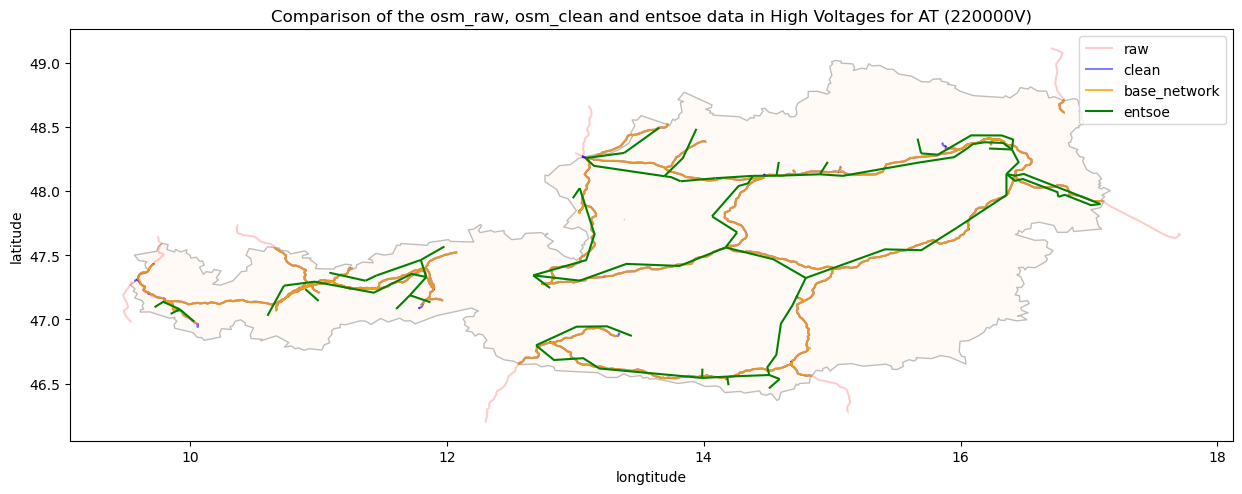

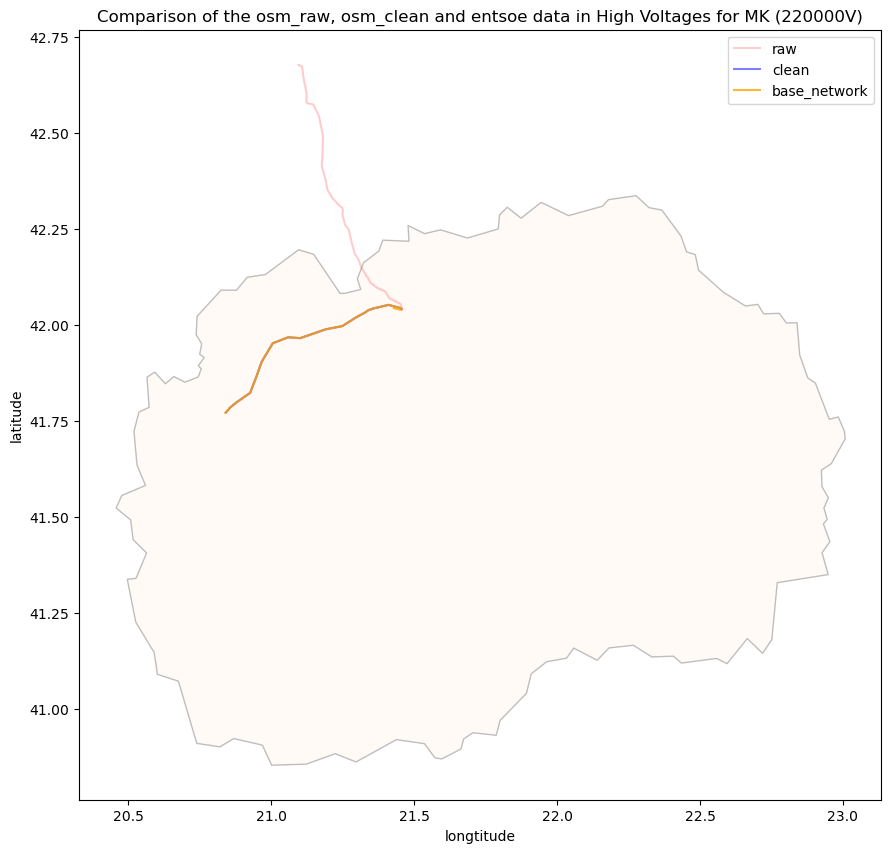

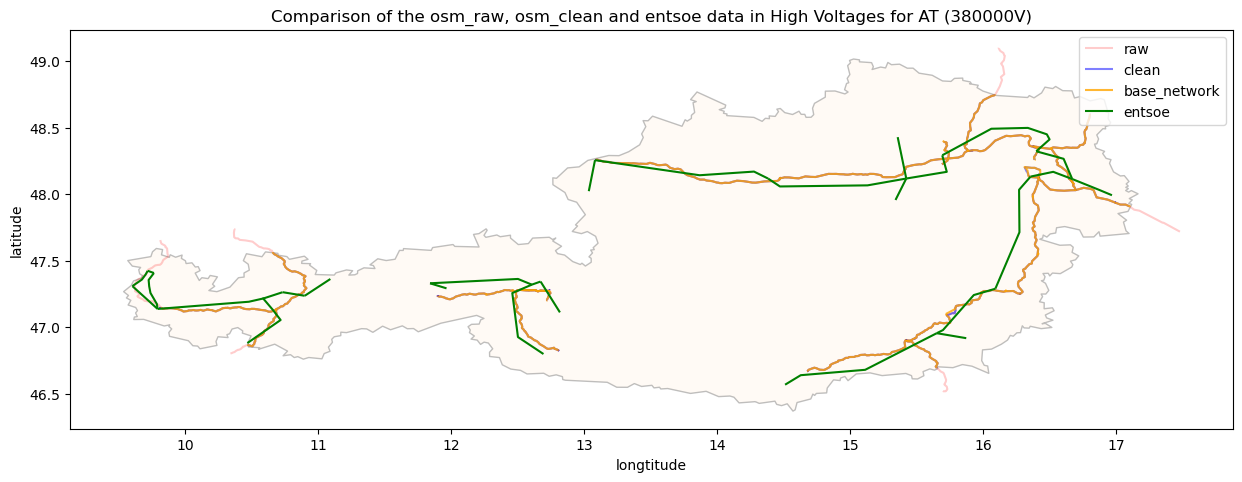

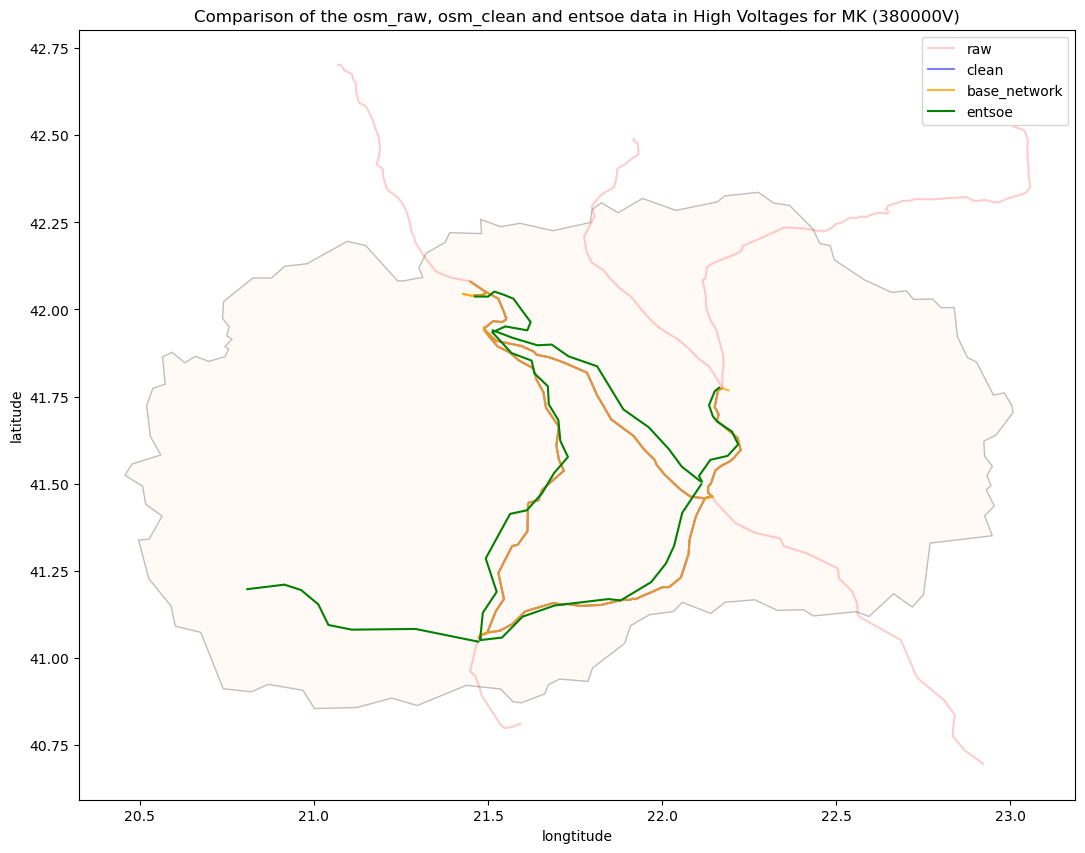

In [13]:
geospatial_plot(220000, "AT", 
                at_country_shape, at_osm_raw_lines, 
                at_osm_clean_lines, at_base_network_lines, entsoe_ref)
geospatial_plot(220000, "MK", 
                mk_country_shape, mk_osm_raw_lines, 
                mk_osm_clean_lines, mk_base_network_lines, entsoe_ref)

geospatial_plot(380000, "AT", 
                at_country_shape, at_osm_raw_lines, 
                at_osm_clean_lines, at_base_network_lines, entsoe_ref)
geospatial_plot(380000, "MK", 
                mk_country_shape, mk_osm_raw_lines, 
                mk_osm_clean_lines, mk_base_network_lines, entsoe_ref)

## Comparison with Barchart

This section aim to investigates the differences in lines length between osm_raw, osm_clean, osm_base_network and ENTSOE data using a barchart.

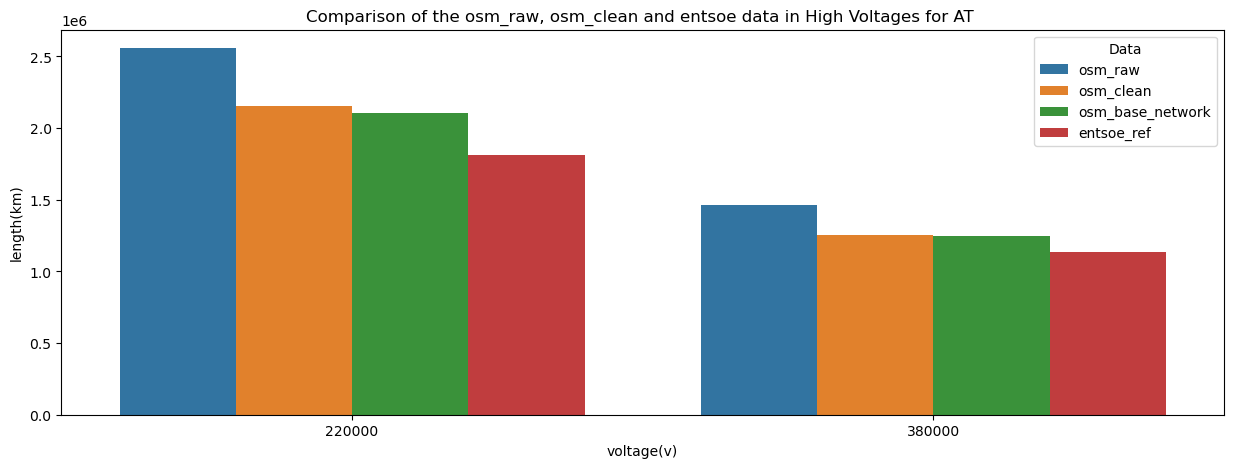

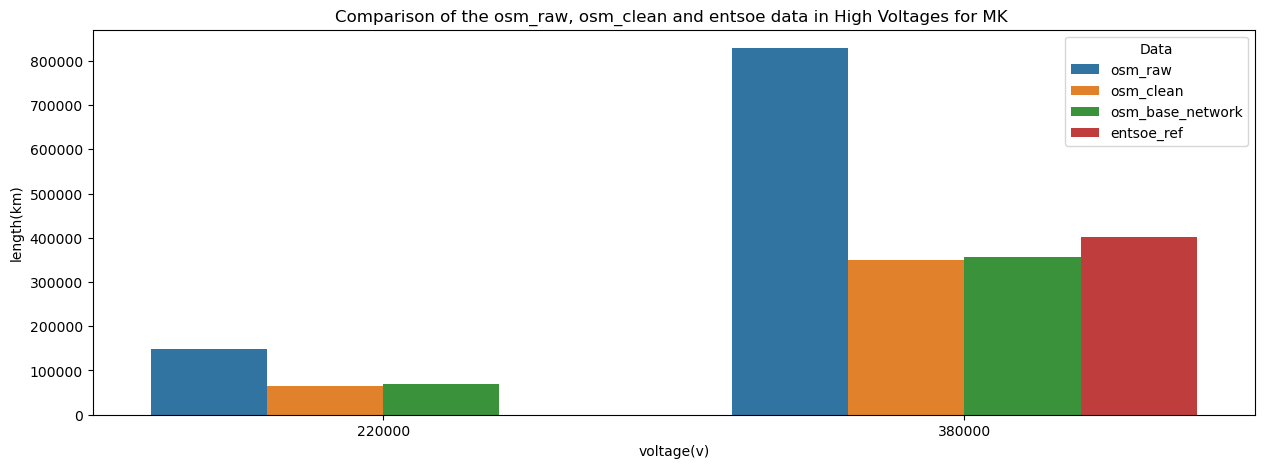

In [14]:
barplot_comparison_plot(at_dataframe, 'at')
barplot_comparison_plot(mk_dataframe, 'mk')

### Table representing sum of length for different voltage levels

In [15]:
at_dataframe.pivot(index='rebase_voltage', columns='data', values='reprojected_length')

data,entsoe_ref,osm_base_network,osm_clean,osm_raw
rebase_voltage,,,,
220000,1812981.04,2102326.46,2157040.88,2558906.49
380000,1138606.97,1246968.95,1256809.15,1461392.83


In [16]:
mk_dataframe.pivot(index='rebase_voltage', columns='data', values='reprojected_length')

data,entsoe_ref,osm_base_network,osm_clean,osm_raw
rebase_voltage,,,,
220000,NaN,68471.69,65680.81,147999.34
380000,401388.57,357167.99,350605.92,828768.56


In [17]:
# percentage change between entsoe data and osm data for Austria

entsoe_reprojected_length_array_at = at_dataframe[
    at_dataframe.data == "entsoe_ref"].reprojected_length.values

at_dataframe['percentage_change'] = at_dataframe.apply(
    lambda row: percentage_change(row.reprojected_length,
                                      entsoe_reprojected_length_array_at[0])
    if row.rebase_voltage == 220000 else percentage_change(
        row.reprojected_length, entsoe_reprojected_length_array_at[1]),
    axis=1)

# dataframe including percentage change
at_dataframe

,rebase_voltage,reprojected_length,data,percentage_change
0,220000,2558906.49,osm_raw,41.14
1,380000,1461392.83,osm_raw,28.35
2,220000,2157040.88,osm_clean,18.98
3,380000,1256809.15,osm_clean,10.38
4,220000,2102326.46,osm_base_network,15.96
5,380000,1246968.95,osm_base_network,9.52
6,220000,1812981.04,entsoe_ref,0.00
7,380000,1138606.97,entsoe_ref,0.00


In [18]:
# percentage change between entsoe data and osm data for North Macedonia

entsoe_reprojected_length_array_mk = mk_dataframe[
    mk_dataframe.data == "entsoe_ref"].reprojected_length.values

mk_dataframe['percentage_change'] = mk_dataframe.apply(
    lambda row: percentage_change(row.reprojected_length,
                                      entsoe_reprojected_length_array_mk[0])
    if row.rebase_voltage == 220000 else percentage_change(
        row.reprojected_length, entsoe_reprojected_length_array_mk[1]),
    axis=1)

# dataframe including percentage change
mk_dataframe

,rebase_voltage,reprojected_length,data,percentage_change
0,220000,147999.34,osm_raw,NaN
1,380000,828768.56,osm_raw,106.48
2,220000,65680.81,osm_clean,NaN
3,380000,350605.92,osm_clean,12.65
4,220000,68471.69,osm_base_network,NaN
5,380000,357167.99,osm_base_network,11.02
6,220000,NaN,entsoe_ref,NaN
7,380000,401388.57,entsoe_ref,0.00


## Section 2 Applying Simplification to OSM data

The reason for simplification is to examine whether it has a direct impact on the length of the lines. Therefore, simplification is applied to OpenStreetMap (OSM) data and compared with ENTSOE data.

ENTSOE-extracted data have a simplified topology, while OSM-extracted lines reproduce topology of a transmission network in quite a detail. To estimate an effect of this simplification, we have applied a simplification procedure to OSM line geometries, as well. Douglas-Peucker simplification algorithm has been applied for that.

In [19]:
def apply_simplication(df:pd.DataFrame, tolerance: float, country_code: str, data_col: str):
    """
    Applying simplification, to_crs and high_voltage_df to dataframe with pandas method chaining
    """

    df = df.copy() \
        .assign(geometry=lambda df: df.geometry.simplify(tolerance)) \
        .assign(reprojected_length=lambda df: df.to_crs("EPSG:3035").length) \
        .pipe(process_high_voltage_df, data_col, country_code.lower)
    
    return df

def process_high_voltage_df(df: pd.DataFrame, source: str, country: str):
    """
    Process a DataFrame for high voltage data by applying the 'high_voltage_df' function.
    """
    return df.pipe(high_voltage_df, source, country)

In [20]:
# Define tolerance level for simplification in meters
tolerance = 0.05

In [21]:
# In the course to understand the effect of simplication on osm_raw, osm_clean and osm_base_network, 
# simiplication is applied to these set of files using the defined tolerance

df_at_osm_clean_lines_copy = apply_simplication(at_osm_clean_lines, tolerance, 'at', 'osm_clean')
df_at_osm_raw_lines_copy = apply_simplication(at_osm_raw_lines, tolerance, 'at', 'osm_raw')
df_at_osm_base_network_copy = apply_simplication(at_base_network_lines, tolerance, 'at', 'osm_base_network')

df_mk_osm_clean_lines_copy = apply_simplication(mk_osm_clean_lines, tolerance, 'mk', 'osm_clean')
df_mk_osm_raw_lines_copy = apply_simplication(mk_osm_raw_lines, tolerance, 'mk', 'osm_raw')
df_mk_osm_base_network_copy = apply_simplication(mk_base_network_lines, tolerance, 'mk', 'osm_base_network')


In [22]:
# merge osm_clean, osm_raw and entsoe preprocess data into a single dataframe
at_dataframe_copy = pd.concat([
    df_at_osm_raw_lines_copy, 
    df_at_osm_clean_lines_copy,
    df_at_osm_base_network_copy, 
    df_at_entsoe_lines], ignore_index=True
    )
    
mk_dataframe_copy = pd.concat([
    df_mk_osm_raw_lines_copy, 
    df_mk_osm_clean_lines_copy, 
    df_mk_osm_base_network_copy,
    df_mk_entsoe_lines], ignore_index=True
)

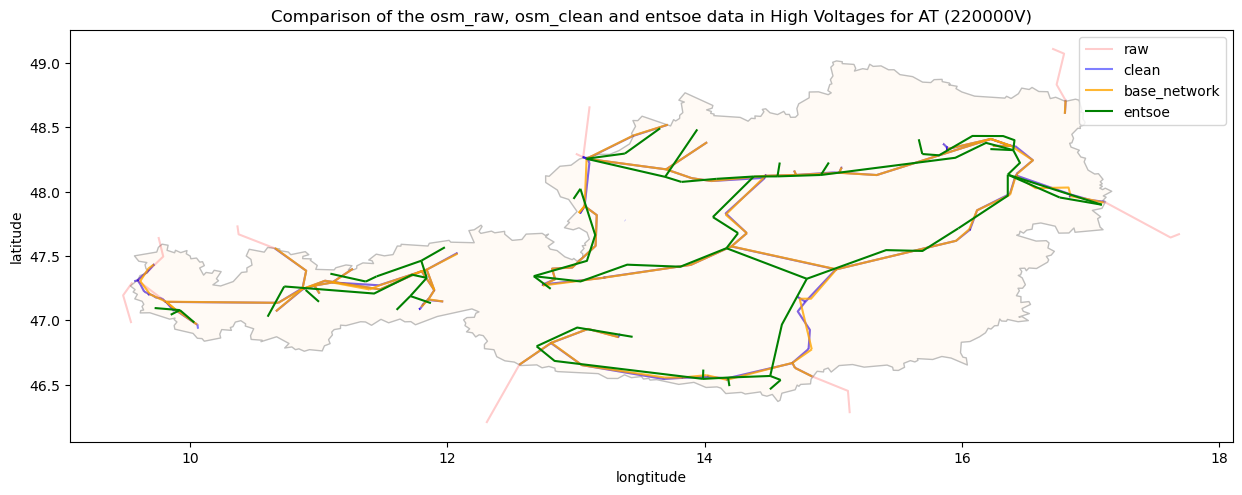

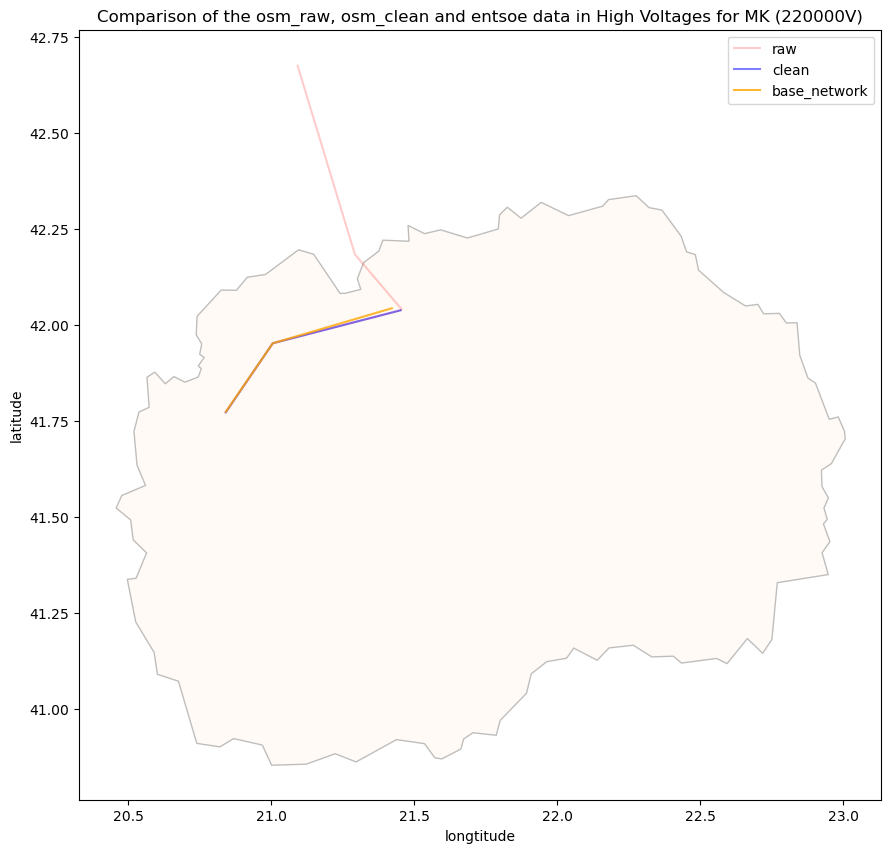

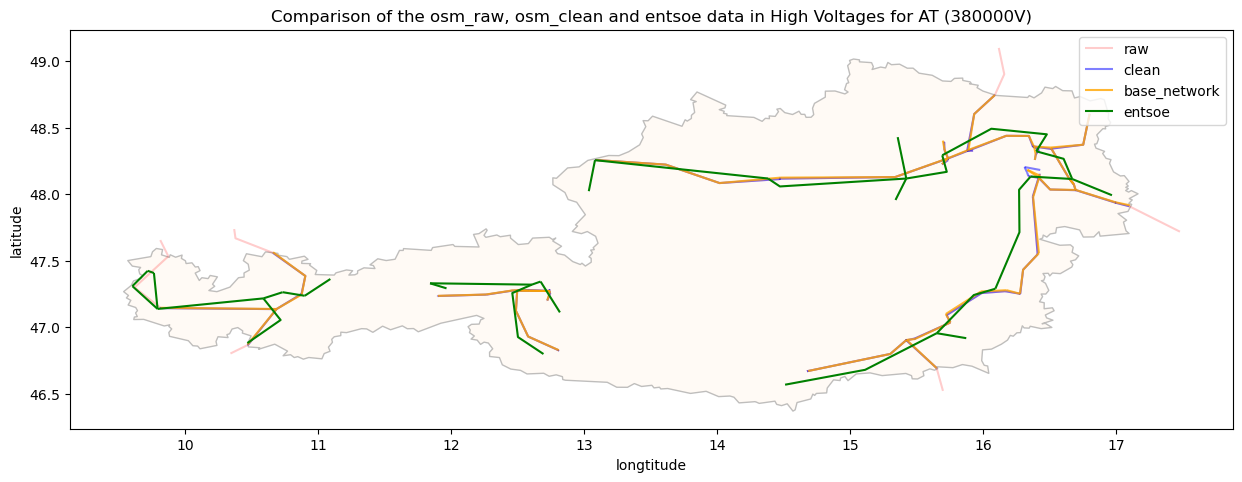

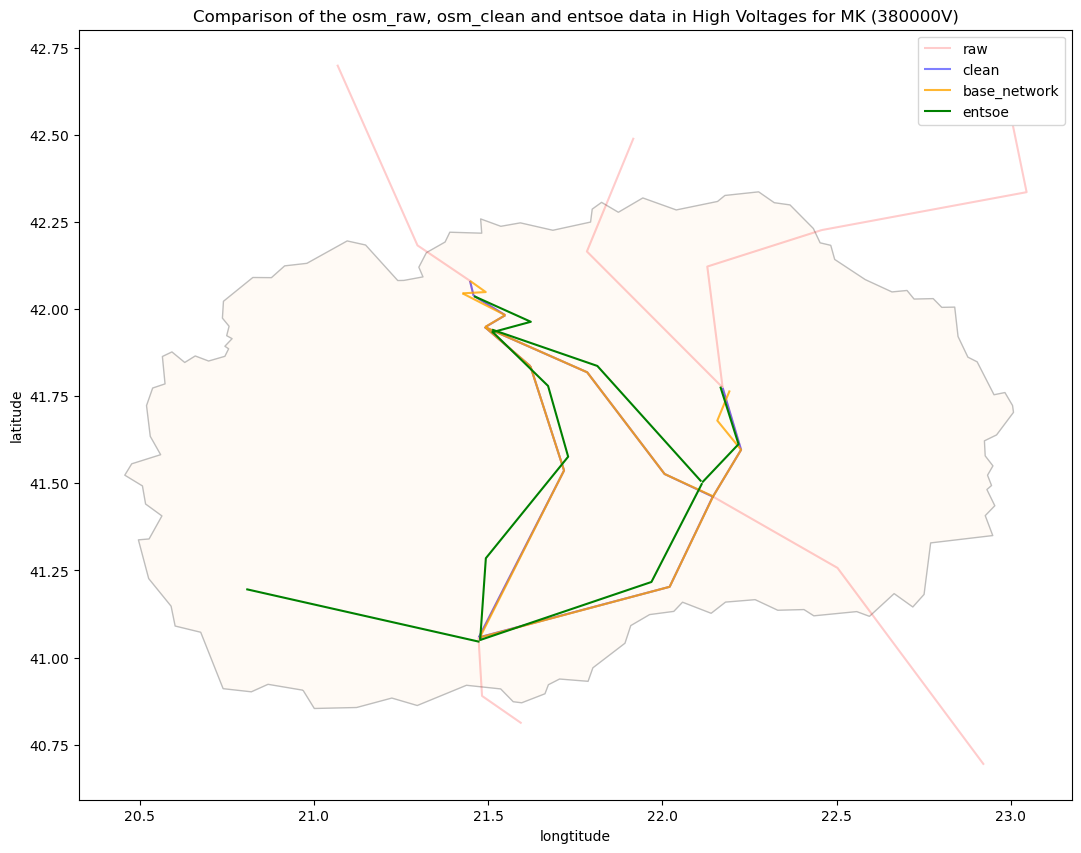

In [23]:
# geospatial plot for different voltage level based on set tolerance level
geospatial_plot(220000, "AT", at_country_shape, 
                at_osm_raw_lines, at_osm_clean_lines, 
                at_base_network_lines, entsoe_ref, tolerance)
geospatial_plot(220000, "MK", mk_country_shape, 
                mk_osm_raw_lines, mk_osm_clean_lines, 
                mk_base_network_lines, entsoe_ref, tolerance)

geospatial_plot(380000, "AT", at_country_shape, 
                at_osm_raw_lines, at_osm_clean_lines, 
                at_base_network_lines, entsoe_ref, tolerance)
geospatial_plot(380000, "MK", mk_country_shape, 
                mk_osm_raw_lines, mk_osm_clean_lines, 
                mk_base_network_lines, entsoe_ref, tolerance)

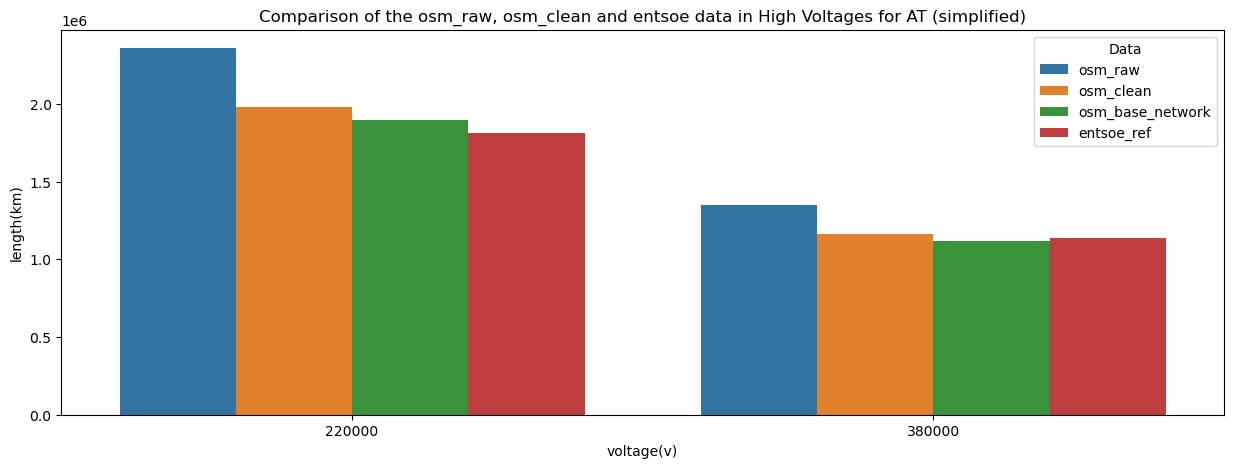

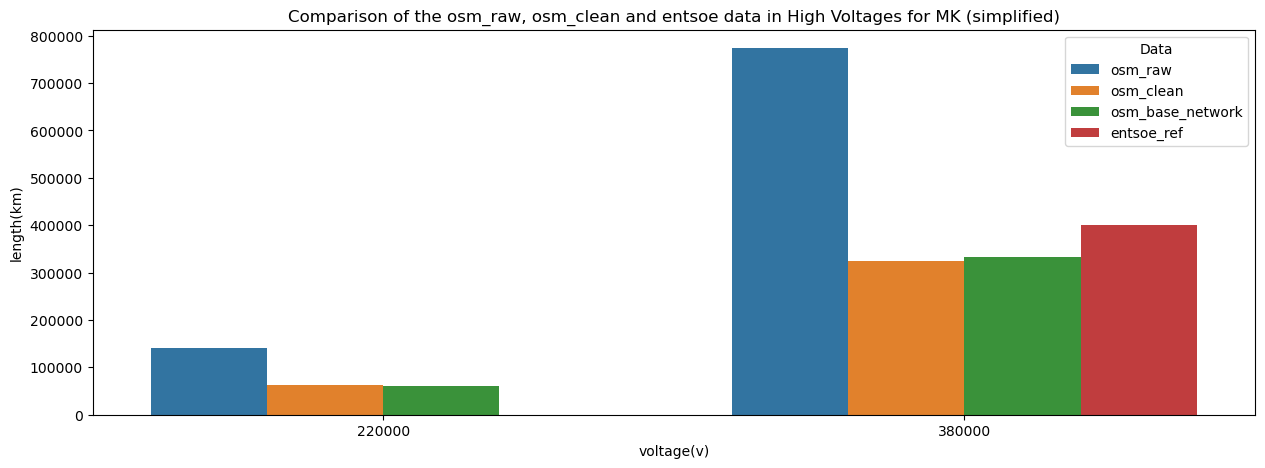

In [24]:
# Create plot using the simplified dataframe

barplot_comparison_plot(at_dataframe_copy, 'at', "(simplified)")
barplot_comparison_plot(mk_dataframe_copy, 'mk', "(simplified)")

In [25]:
# creating an additional column to include percentage change of osm vs entsoe data after simplification
at_dataframe_copy['percentage_change_simplified'] = at_dataframe_copy.apply(
    lambda row: percentage_change(row.reprojected_length,
                                      entsoe_reprojected_length_array_at[0])
    if row.rebase_voltage == 220000 else percentage_change(
        row.reprojected_length, entsoe_reprojected_length_array_at[1]),
    axis=1)

at_dataframe_copy

,rebase_voltage,reprojected_length,data,percentage_change_simplified
0,220000,2359485.07,osm_raw,30.14
1,380000,1348631.38,osm_raw,18.45
2,220000,1981705.68,osm_clean,9.31
3,380000,1161199.82,osm_clean,1.98
4,220000,1896980.46,osm_base_network,4.63
5,380000,1118132.04,osm_base_network,1.80
6,220000,1812981.04,entsoe_ref,0.00
7,380000,1138606.97,entsoe_ref,0.00


In [26]:
# creating an additional column to include percentage change of osm vs entsoe data after simplification
mk_dataframe_copy['percentage_change_simplified'] = mk_dataframe_copy.apply(
    lambda row: percentage_change(row.reprojected_length,
                                      entsoe_reprojected_length_array_mk[0])
    if row.rebase_voltage == 220000 else percentage_change(
        row.reprojected_length, entsoe_reprojected_length_array_mk[1]),
    axis=1)

mk_dataframe_copy

,rebase_voltage,reprojected_length,data,percentage_change_simplified
0,220000,141233.53,osm_raw,NaN
1,380000,773999.61,osm_raw,92.83
2,220000,63315.45,osm_clean,NaN
3,380000,324961.10,osm_clean,19.04
4,220000,60852.90,osm_base_network,NaN
5,380000,332271.28,osm_base_network,17.22
6,220000,NaN,entsoe_ref,NaN
7,380000,401388.57,entsoe_ref,0.00


## Simplified vs Non Simplified

This section aims to compare results from the simplified analysis against results from the non-simplified analysis.

In [27]:
def simplified_plot(df: pd.DataFrame, country_code: str) -> None:
    """
    Functions plots a comparison plot between simplified data and non_simplified data for osm and entsoe
    """
    plt.figure(figsize=(15, 5))
    sns.barplot(x="rebase_voltage", y="reprojected_length", hue="data", data=df, palette='Set1')

    plt.xlabel("voltage(v)")
    plt.ylabel("length(km)")
    plt.title(
        f"Comparison of the osm_raw, osm_clean and entsoe data in High Voltages for {country_code.upper()}"
    )
    plt.legend(title="Data", loc="upper right")
    plt.show()

    return None

In [28]:
# percentage change comparison between non-simplified data and simplified data for Austria
at_dataframe.merge(at_dataframe_copy,
                   on=['rebase_voltage', 'data'],
                   suffixes=[None, "_simpl"]).sort_index(axis=1)


,data,percentage_change,percentage_change_simplified,rebase_voltage,reprojected_length,reprojected_length_simpl
0,osm_raw,41.14,30.14,220000,2558906.49,2359485.07
1,osm_raw,28.35,18.45,380000,1461392.83,1348631.38
2,osm_clean,18.98,9.31,220000,2157040.88,1981705.68
3,osm_clean,10.38,1.98,380000,1256809.15,1161199.82
4,osm_base_network,15.96,4.63,220000,2102326.46,1896980.46
5,osm_base_network,9.52,1.80,380000,1246968.95,1118132.04
6,entsoe_ref,0.00,0.00,220000,1812981.04,1812981.04
7,entsoe_ref,0.00,0.00,380000,1138606.97,1138606.97


In [29]:
# percentage change comparison between non-simplified data and simplified data for North Macedonia
mk_dataframe.merge(mk_dataframe_copy,
                   on=['rebase_voltage', 'data'],
                   suffixes=[None, "_simpl"]).sort_index(axis=1)


,data,percentage_change,percentage_change_simplified,rebase_voltage,reprojected_length,reprojected_length_simpl
0,osm_raw,NaN,NaN,220000,147999.34,141233.53
1,osm_raw,106.48,92.83,380000,828768.56,773999.61
2,osm_clean,NaN,NaN,220000,65680.81,63315.45
3,osm_clean,12.65,19.04,380000,350605.92,324961.10
4,osm_base_network,NaN,NaN,220000,68471.69,60852.90
5,osm_base_network,11.02,17.22,380000,357167.99,332271.28
6,entsoe_ref,NaN,NaN,220000,NaN,NaN
7,entsoe_ref,0.00,0.00,380000,401388.57,401388.57


In [30]:
# replacing the columns names before concatenating with the original dataframe

at_dataframe_copy = at_dataframe_copy.replace({
    "osm_raw": "osm_raw_sim", 
    "osm_clean": "osm_clean_sim", 
    "osm_base_network": "osm_base_network_sim"})
mk_dataframe_copy = mk_dataframe_copy.replace({
    "osm_raw": "osm_raw_sim", 
    "osm_clean": "osm_clean_sim", 
    "osm_base_network": "osm_base_network_sim"})


In [31]:
# concat the original dataframe with the simplified dataframe

df_at = pd.concat([at_dataframe, at_dataframe_copy])
df_at = df_at.sort_values(['reprojected_length', 'data'], ascending=False)
df_at.reset_index(drop=True, inplace=True)

df_mk = pd.concat([mk_dataframe, mk_dataframe_copy])
df_mk = df_mk.sort_values(['reprojected_length', 'data'], ascending=False)
df_mk.reset_index(drop=True, inplace=True)

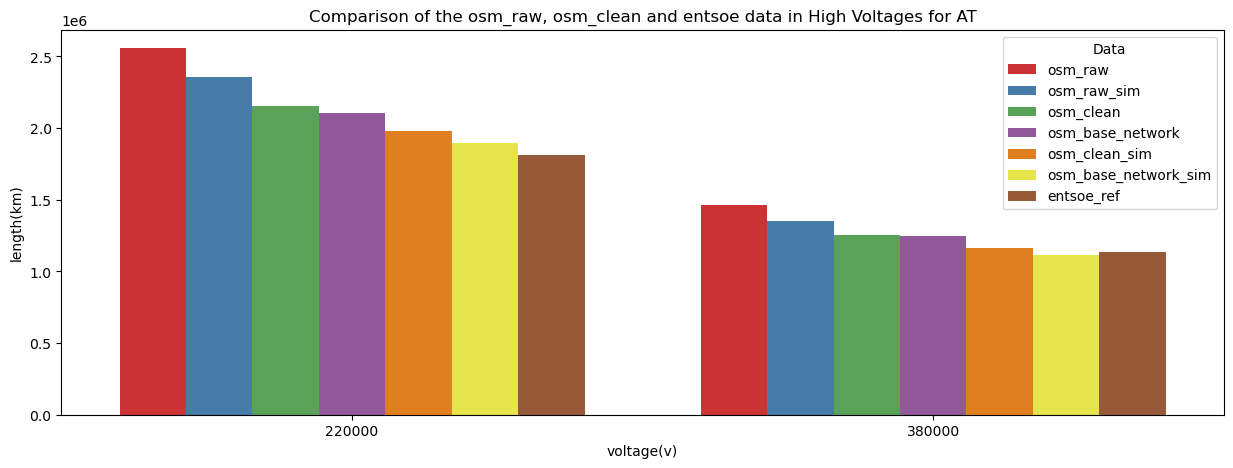

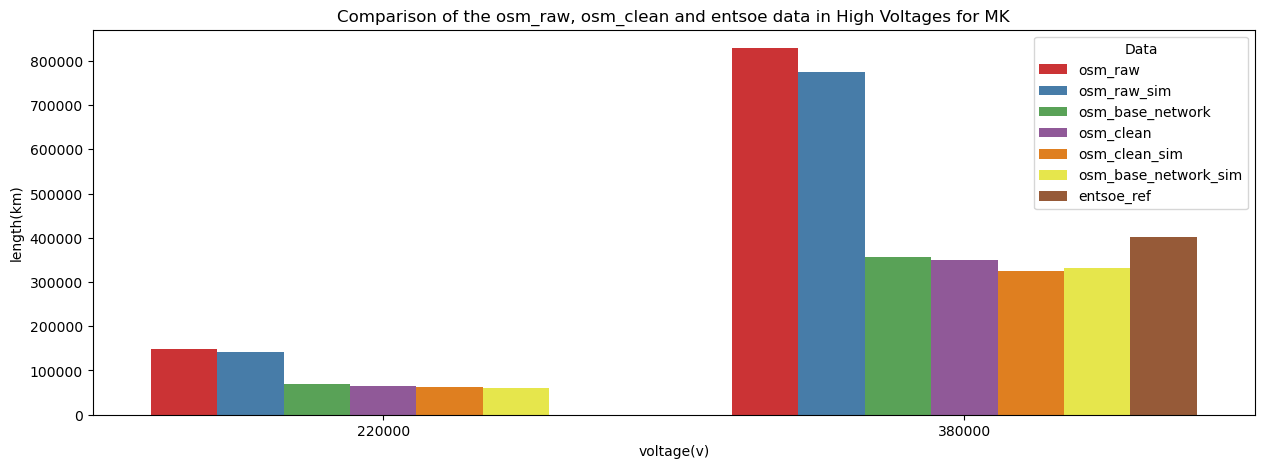

In [32]:
simplified_plot(df_at, 'at')
simplified_plot(df_mk, 'mk')

## CRS Check

There is a need to confirm that the length of lines in OSM data corresponds to the lines length measured on google maps. Lines length measured manually on google maps can be reproduced using geopy.

In [33]:
def compute_length(df:pd.DataFrame, column: str, idx: int) -> int:
    """
    This function calculates the length of a line specified by its index in the DataFrame.
    It does this by extracting the latitude and longitude pairs from the 'lonlat' column
    and computing the distance between consecutive points using the Haversine formula.
    The result is returned in meters.
    """
    long = []
    lat = []

    # extract the latitude and logititude from the geometry column
    line = df[column][idx]
    for idx in range(0, len(line)):
        long.append(line[idx][0])
        lat.append(line[idx][1])

    # looping through the latitude and longitude to calculate the distance
    length = 0
    for lat_idx, long_idx in zip(range(len(lat)-1), range(len(long)-1)):
        loc1 = (lat[lat_idx], long[long_idx])
        loc2 = (lat[lat_idx + 1], long[long_idx + 1])

        length += GD(loc1, loc2).km # measure distance between two points and sum into length
    return length * 1000

def plot_diff(df, col, idx):
    """
    This function return the lengths of line from OSM data and measurement done with geopy using the 'compute_length' function.
    It then creates a bar chart to visually compare the lengths of the two lines.
    """
    geopy_len = compute_length(df, col, idx) # calculate length of lines using geopy with compute_length func
    osm_len = df.to_crs("EPSG:3035").length[idx] # extract length from osm_data

    print(f"osm_length: {osm_len}")
    print(f"geopy_length: {geopy_len}")
    print(f"difference is: {osm_len - geopy_len}")
    
    #create barchart to compare osm_length with gmap length
    plt.bar(["osm_length", "geopy_length"], [osm_len, geopy_len])
    plt.title("length comparison")
    plt.ylabel("meters")
    plt.show()



In [34]:
# extract coordinate from the geometry column using AT OSM clean lines that was loaded above
at_osm_clean_lines['coords'] = at_osm_clean_lines.apply(lambda row: [y for  y in row['geometry'].coords], axis=1)

lines length measured on google maps manually for the first set of cordinates in the osm_clean_lines data for Austria

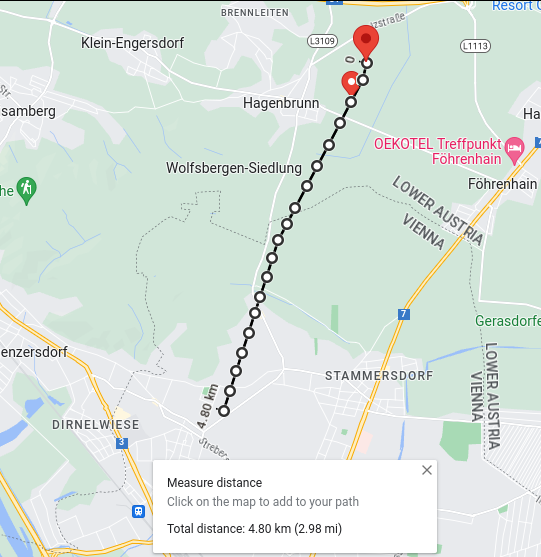

osm_length: 4800.0000976269275
geopy_length: 4796.026913802886
difference is: 3.973183824041371


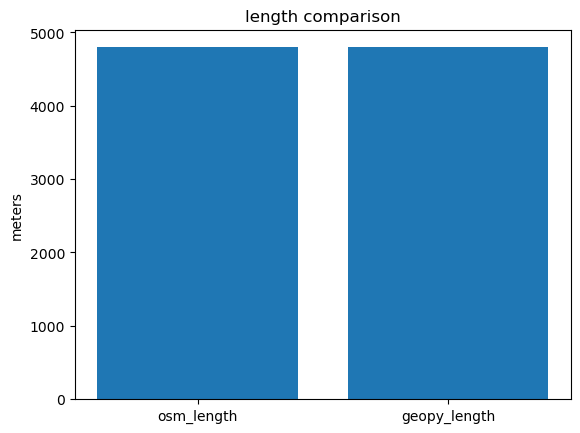

In [35]:
plot_diff(at_osm_clean_lines, "coords", 0) # index can be changed to check for other lines in the dataframe

# Conclusion

Our analysis focused on examining quality of OpenStreetMap (OSM) data, constituting the entirety of PyPSA-Earth data preparation workflow in part of power grid data. OSM-extracted data refers to geographic and spatial information for power infrastructure obtained from the OpenStreetMap database. 

This data was compared with European Network of Transmission System Operators for Electricity (ENTSOE) database. We conducted two types of comparisons: one centered around topology and another involving quantitative assessments of length values. The results revealed indications of potential simplification methods applied to ENTSO data, prompting further investigation.

A hypothesis was tested by applying the geopandas simplify method, leveraging the Douglas-Peucker algorithm. This approach yielded satisfactory results, demonstrating that simplified OSM topologies improves alignment of OSM-derived data with ENTSO data.

Our analysis has indicated that for Europe, OSM provides a more intricate and precise representation of actual grid topology compared to ENTSO-data. 

Quantitatively, OSM data closely align with ENTSO data, with the difference being about 9-15% for Austria and 11% for Northern Macedonia. The absence of 220kV lines discovered for North Macedonia in the ENTSOE dataset and the evident simplification process applied to ENTSOE data further underscore the advantages of relying on OSM data for comprehensive analyses. To ensure robust validation, we recommend utilizing the CSVs from PyPSA-Earth extraction workflow specifically base_network/all_lines_build_network.csv  for OSM data, as opposed to elec.nc, where voltage levels have been rebased to a few standard voltage thresholds.